<a href="https://colab.research.google.com/github/Kaan-wq/ml_tokamak/blob/main/NN_general.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import math
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches
import os
import glob
import numpy as np
from typing import Iterable
import pickle
import tensorflow as tf
from scipy.fft import fft, ifft
from statsmodels.tsa.stattools import acf, pacf
from sklearn.decomposition import PCA

import keras
import keras_tuner as kt
from kerastuner import RandomSearch
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import layers
from tensorflow.keras import regularizers

#**I - Preprocessing of the data**

Below is the preprocessing pipeline of the data. \\
Essentially, we feature engineer a few columns, normalize the data and finally, we split it into a training and testing set.

In [7]:
# load dataset using pickle
import pickle
with open("../data/dataset_disruption_characterization.pickle", "rb") as f:
    dataset = pickle.load(f)

Here we load the data from the drive and put it into a more practical **data structure**. \\
We add a column <code>['IPE']</code> which represents the current difference between the reference and actual currents.

In [8]:
# Define columns to perform feature engineering on
columns = ['IPLA', 'IPref', 'IPE', 'ECEcore', 'SSXcore', 'LI', 'Q95', 'ZMAG', 'Vloop']

# Define the operations to perform on each column
operations = {
    'fft_abs': lambda x: np.abs(np.fft.fft(x)),
    'der': np.gradient,
    'der2': lambda x: np.gradient(np.gradient(x))
}

df_data = pd.DataFrame()

# Loop through each entry in the dataset
for i, entry in enumerate(dataset):
    # Extract data and label from the current entry
    d = entry['x']
    label = entry['y']
    metadata = entry['metadata']
    event = metadata['time_event']

    # Create a DataFrame for the current entry
    df = pd.DataFrame(d['data'], columns=d['columns'])

    # Add the IPE column
    df['IPE'] = np.abs(df['IPLA'] - df['IPref'])

    # Perform feature engineering on each column
    new_cols = {}
    for col in columns:
        for op_name, op_func in operations.items():
            new_cols[col + '_' + op_name] = op_func(df[col])

    # Create a new DataFrame with the new columns
    df_new = pd.DataFrame(new_cols)

    # Concatenate the original DataFrame with the new one
    df = pd.concat([df, df_new], axis=1)
    
    # Add the time column
    df['Time'] = d['time']

    # Add the Frame, Event, Label, Shot and Window columns
    df['Frame'] = range(0, 20)
    df['Event'] = event if event else 0

    if event:
        # Find closest points to time_event
        differences = np.abs(df['Time'] - event)
        closest_indices = np.argsort(differences)[:20]

        # Assign labels to closest points
        df['Label'] = 0
        df.loc[closest_indices, 'Label'] = label
    else:
        df['Label'] = label

    df['Shot'] = metadata['shot']
    df['Window'] = i  # Add the window number

    contains_nan = df.isna().any().any()

    if not contains_nan:
        # Append the current DataFrame to the main DataFrame
        df_data = pd.concat([df_data, df], ignore_index=True)

df_data = df_data.dropna()
display(df_data)
print("Labels count:")
print(f"{df_data['Label'].value_counts()}")

base_col = df_data.columns

,IPLA,IPref,ECEcore,SSXcore,LI,Q95,ZMAG,Vloop,IPE,IPLA_fft_abs,...,ZMAG_der2,Vloop_fft_abs,Vloop_der,Vloop_der2,Time,Frame,Event,Label,Shot,Window
0,1989456.750,1999500.0,1740.929077,0.008850,1.191489,3.874169,0.30388,-0.519496,10043.250,3.978742e+07,...,0.0,15.597891,-0.238922,-0.019993,10.361,0,0.0,0,81206,0
1,1989606.250,1999500.0,1744.737427,0.008850,1.191489,3.874169,0.30388,-0.758418,9893.750,2.153723e+03,...,0.0,1.771412,-0.258915,0.119461,10.362,1,0.0,0,81206,0
2,1988484.000,1999500.0,1756.823730,0.008698,1.191489,3.874169,0.30388,-1.037327,11016.000,4.264020e+03,...,0.0,3.078187,0.000000,0.448103,10.363,2,0.0,0,81206,0
3,1989329.625,1999500.0,1756.823730,0.008469,1.191489,3.874169,0.30388,-0.758418,10170.375,5.440219e+03,...,0.0,2.395747,0.637292,-0.159448,10.364,3,0.0,0,81206,0
4,1990532.250,1999500.0,1746.057251,0.008850,1.191489,3.874169,0.30388,0.237256,8967.750,4.025099e+03,...,0.0,2.711081,-0.318896,-0.537741,10.365,4,0.0,0,81206,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17975,3993662.500,4000500.0,6282.263672,1.416517,0.808256,2.898196,0.32961,-0.316564,6837.500,1.188296e+04,...,0.0,3.688298,-0.138622,0.138705,8.622,15,0.0,0,98005,905
17976,3995614.250,4000500.0,6303.055664,1.410871,0.808256,2.898196,0.32961,-0.237256,4885.750,6.513881e+03,...,0.0,2.476415,0.038821,0.198435,8.623,16,0.0,0,98005,905
17977,3994348.000,4000500.0,6277.216309,1.402783,0.808256,2.898196,0.32961,-0.238922,6152.000,9.370845e+03,...,0.0,2.202090,0.258249,0.000416,8.624,17,0.0,0,98005,905
17978,3997734.500,4000500.0,6286.124512,1.391034,0.808256,2.898196,0.32961,0.279242,2765.500,1.626988e+04,...,0.0,1.736529,0.039654,-0.348553,8.625,18,0.0,0,98005,905


Labels count:
Label
0    12840
1     4140
2     1000
Name: count, dtype: int64


We **normalize and split** into training and test sets before feeding it into our **Neural Network**.

In [9]:
# Split 'Shot' values into training and test sets and create DataFrames
shot_train, shot_test = train_test_split(df_data['Shot'].unique(), test_size=0.2, random_state=42)
train_df = df_data[df_data['Shot'].isin(shot_train)]
test_df = df_data[df_data['Shot'].isin(shot_test)]

# Group by 'Window' and 'Shot', and reshape the data
train_df_grouped = train_df.sort_values(['Shot', 'Window', 'Time']).groupby(['Shot', 'Window'])
test_df_grouped = test_df.sort_values(['Shot', 'Window', 'Time']).groupby(['Shot', 'Window'])

# Prepare lists to hold sequences
X_train_grouped, y_train_grouped = [], []
X_test_grouped, y_test_grouped = [], []

# Generate sequences for training data
for _, group in train_df_grouped:
    X_train_grouped.append(group.drop(columns=['Frame', 'Event', 'Label', 'Shot', 'Window']).values)
    y_train_grouped.append(group['Label'].values[0])  # Assuming all labels in a group are the same

# Generate sequences for testing data
for _, group in test_df_grouped:
    X_test_grouped.append(group.drop(columns=['Frame', 'Event', 'Label', 'Shot', 'Window']).values)
    y_test_grouped.append(group['Label'].values[0])  # Assuming all labels in a group are the same

# Convert lists to numpy arrays
X_train_grouped = np.array(X_train_grouped)
y_train_grouped = np.array(y_train_grouped)
X_test_grouped = np.array(X_test_grouped)
y_test_grouped = np.array(y_test_grouped)

# Normalize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_grouped.reshape(-1, X_train_grouped.shape[-1])).reshape(X_train_grouped.shape)
X_test = scaler.transform(X_test_grouped.reshape(-1, X_test_grouped.shape[-1])).reshape(X_test_grouped.shape)

# Convert labels to categorical
y_train = to_categorical(y_train_grouped)
y_test = to_categorical(y_test_grouped)

In [10]:
# Save the scaler
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [11]:
X_train.shape

(737, 20, 37)

#**II - Model tuning**

Here we use the hyperparamter tuner from keras to find the best model architecture.

In [32]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, Add, GlobalAveragePooling1D, Dense
from tensorflow.keras.optimizers import Adam

# Function for creating a residual block
def residual_block(x, filters, kernel_size):
    # Save the input value. Apply a 1x1 convolution to match the number of channels.
    residual = Conv1D(filters, 1, padding='same')(x)

    # Convolution, batch normalization, and ReLU activation (repeated three times)
    for _ in range(3):
        x = Conv1D(filters, kernel_size, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

    # Add the residual (input) to the output
    x = Add()([x, residual])

    return x

# Input shape: (timesteps, features)
input_shape = (20, 37)

# Input layer
input_layer = Input(shape=input_shape)

# Create three residual blocks with varying kernel sizes
x = residual_block(input_layer, 32, 21)
x = residual_block(x, 32, 3)
x = residual_block(x, 96, 5)

# Global Average Pooling layer
x = GlobalAveragePooling1D()(x)

# Final softmax classifier
output_layer = Dense(3, activation='softmax')(x)

# Create the model and compile it
model = Model(inputs=input_layer, outputs=output_layer)

# Create the optimizer
optimizer = Adam(learning_rate=1e-7)

# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', tfa.metrics.F1Score(num_classes=3, average=None)])

# Print the model summary
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 20, 37)]             0         []                            
                                                                                                  
 conv1d_121 (Conv1D)         (None, 20, 32)               24896     ['input_11[0][0]']            
                                                                                                  
 batch_normalization_90 (Ba  (None, 20, 32)               128       ['conv1d_121[0][0]']          
 tchNormalization)                                                                                
                                                                                                  
 activation_90 (Activation)  (None, 20, 32)               0         ['batch_normalization_9

Epoch 1/5000
24/24 [==============================] - 4s 32ms/step - loss: 1.1869 - accuracy: 0.4220 - f1_score: 0.2560 - val_loss: 1.4676 - val_accuracy: 0.1358 - val_f1_score: 0.0950
Epoch 2/5000
24/24 [==============================] - 0s 16ms/step - loss: 1.2027 - accuracy: 0.4138 - f1_score: 0.2604 - val_loss: 1.4292 - val_accuracy: 0.1914 - val_f1_score: 0.1147
Epoch 3/5000
24/24 [==============================] - 0s 17ms/step - loss: 1.1957 - accuracy: 0.4233 - f1_score: 0.2586 - val_loss: 1.3915 - val_accuracy: 0.2346 - val_f1_score: 0.1349
Epoch 4/5000
24/24 [==============================] - 0s 17ms/step - loss: 1.1808 - accuracy: 0.4288 - f1_score: 0.2635 - val_loss: 1.3595 - val_accuracy: 0.3272 - val_f1_score: 0.1797
Epoch 5/5000
24/24 [==============================] - 0s 17ms/step - loss: 1.1865 - accuracy: 0.4179 - f1_score: 0.2528 - val_loss: 1.3369 - val_accuracy: 0.3951 - val_f1_score: 0.2125
Epoch 6/5000
24/24 [==============================] - 0s 17ms/step - loss: 

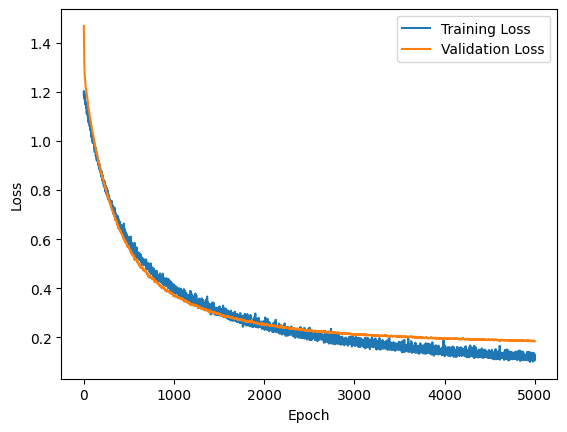

6/6 [==============================] - 0s 5ms/step - loss: 0.1848 - accuracy: 0.9444 - f1_score: 0.8426
F1-score on validation set: [0.9770993  0.8235294  0.72727275]


In [33]:
# Train the model
history = model.fit(X_train, y_train, epochs=5000, validation_data=(X_test, y_test))

# Plot the losses
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Print the F1-score on the validation set
_, _, f1_score = model.evaluate(X_test, y_test)
print('F1-score on validation set:', f1_score)

#**III - Hyper-parameter tuning**

We use keras tuner to find the best hyper-parameters for our Residual Network.


In [47]:
import keras_tuner as kt

# Define the function to build the model with hyperparameters
def build_model(hp):
    input_layer = Input(shape=input_shape)
    x = input_layer

    for i in range(3):
        # Define hyperparameters for the number of filters and kernel size
        filters = hp.Int('filters_' + str(i), min_value=32, max_value=128, step=32)
        kernel_size = hp.Choice('kernel_size_' + str(i), values=[3, 5, 8, 13, 21])

        x = residual_block(x, filters, kernel_size)

    x = GlobalAveragePooling1D()(x)
    # Final softmax classifier
    output_layer = Dense(3, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=output_layer)

    # Define hyperparameters for the learning rate
    learning_rate = 1e-4

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy', tfa.metrics.F1Score(num_classes=3, average=None)]
    )

    return model

# Create the tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,  # Number of hyperparameter combinations to try
    executions_per_trial=1,  # Number of models to train for each trial
    directory='my_dir',  # Directory where the hyperparameters will be saved
    project_name='resnet_hyperparam_tuning'
)

# Perform the hyperparameter search
tuner.search(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters
print("Best Hyperparameters:")
print(best_hps.values)

Reloading Tuner from my_dir/resnet_hyperparam_tuning/tuner0.json
Best Hyperparameters:
{'filters_0': 32, 'kernel_size_0': 21, 'filters_1': 32, 'kernel_size_1': 3, 'filters_2': 96, 'kernel_size_2': 5}


In [49]:
from sklearn.metrics import classification_report

# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model
_, _, f1_score = best_model.evaluate(X_test, y_test)

# Print the F1-score on the validation set for each class
print('F1-score on validation set:')
print(f1_score)

# Predict the classes
y_pred = best_model.predict(X_test)

# Convert the predictions and true values to their original classes if they are one-hot encoded
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Get the classification report
report = classification_report(y_test_classes, y_pred_classes, output_dict=True)

# The weighted F1-score is available in the 'weighted avg' key in the report
weighted_f1_score = report['weighted avg']['f1-score']

print('Weighted F1-score on validation set:')
print(weighted_f1_score)

# Save the model
best_model.save(filepath='../models/resnet.keras', overwrite=True, save_format='keras')

# Save the model's weights
best_model.save_weights('../models/resnet_weights.h5')

6/6 [==============================] - 1s 5ms/step - loss: 0.1452 - accuracy: 0.9691 - f1_score: 0.9372
F1-score on validation set:
[0.9847328  0.893617   0.93333334]
6/6 [==============================] - 0s 3ms/step
Weighted F1-score on validation set:
0.9684507780297577
